# Exploratory data analysis
For this exploration of the data the files are read in and inspected for missing values, data types and availability of data needed to answer business questions.

In [1]:
import pandas as pd
import seaborn as sns

## Questions
1. Which factors influence a properties base listing price the most?
2. Are certain types of houses booked more than other?
  - Does the area where they stay matter?
  
  
  
Thoughts on potential questions:
- Are certain types of houses more often booked than others
- Look at the price fluctuations of the houses, does this differ between apartments and houses?
  - To do this, need to rescale the price increases between 0 and 1 and check a ratio in price increase vs absolute number
- 

Er zijn locatie gegevens, misschien iets doen met number of airbnb properties per district

In [2]:
def df_summary_overview(df):
    """Take a pandas DataFrame and display the shape, provide info on the columns
    and display the 5 first and 5 last rows of the data. 5 last to see if there are total/summary
    rows included in the data
    """
    # print shape information
    rows, columns = df.shape
    print(f'This dataset has {rows} rows & {columns} columns\n')
    
    # Display a small example
    display(df.head(5))
    display(df.tail(5))
    
    # Describe the dataframe
    display(df.info(memory_usage=False))


def clean_and_cast_price(price):
    """Take the price and clean the commas and dollar signs"""
    if pd.isnull(price):
        return price
    else:
        return price.replace('$','').replace(',','')

## Looking at the calendar data

- The data has three columns and seems to only have missing values for the `price` column.
- The `date` column is an object, for each of processing lets turn this into a datetime column
- The `available` column is a boolean but is stored as object with t/f values.
- The prices have a `$` symbol and are stored as objects.


In [3]:
calendar = pd.read_csv('data/airbnb_seatle/calendar.csv')
df_summary_overview(calendar)

This dataset has 1393570 rows & 4 columns



,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


,listing_id,date,available,price
1393565,10208623,2016-12-29,f,NaN
1393566,10208623,2016-12-30,f,NaN
1393567,10208623,2016-12-31,f,NaN
1393568,10208623,2017-01-01,f,NaN
1393569,10208623,2017-01-02,f,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)

None

### Preprocess calendar data
- Clean price column, remove $ and comma for thousands and cast to float
- Cast the available column to boolean
- Change the date column to a datetime object

In [4]:
# Clean the $ sign from the price column, remove the commas (,) for the thousands and cast to float
calendar.loc[:,'price'] = (calendar['price']
                           .apply(clean_and_cast_price)
                           .astype(float)
                          )

In [5]:
# Change available column to boolean
calendar.loc[:,'available'] = calendar['available'] == 't'

In [6]:
# Update datetype for date
calendar.loc[:,'date'] = pd.to_datetime(calendar['date'])

### Explore calendar data
- Check the missing values in the pricing column
- See if some listings are missing all pricing information
- Check pricing range, any outliers?

In [7]:
# Check for which dates the price is missing, looks like this might be tied to availability

# Select only unavailable rooms, check unique list of prices
print(f"Unique prices in unavailable rooms: {calendar.loc[~calendar['available'],'price'].unique()}")


# Check null values in available listings
print(f"Available rooms, price unknown: {calendar.loc[calendar['available'],'price'].isnull().sum()}")

Unique prices in unavailable rooms: [nan]
Available rooms, price unknown: 0


In [8]:
# Are there properties for which the price is unknown?
# Use groupby with maximum price to determine
calendar_max_prices = calendar.groupby('listing_id').price.max()

# listings missing prices, check listing data to get prices?
calendar_listings_no_price = calendar_max_prices[calendar_max_prices.isnull()].index.tolist()


print(f"There are {len(calendar_listings_no_price)} listings that do not have a price in the calendar at all")

# Missing a price might be in the listings data file.

There are 95 listings that do not have a price in the calendar at all


In [9]:
# Prices per listing seem to change over time. Only ~13% of the listings have 1 price for the whole year,\
# The rest is subject to change

number_of_pricings = calendar.groupby('listing_id').apply(lambda x: x.price.unique().size).value_counts()
print(f'Number of listings with same price for the whole year: {number_of_pricings[1]/number_of_pricings.sum()*100:.2f}%')

Number of listings with same price for the whole year: 12.83%


## Looking at the Listings data
The listings data has a lot of columns with information around the listing. It includes summary summary statistics on the listing like number of reviews, average review rating, location of the listing and information about the listing in general.

For the EDA, lets have a look at some of the columns and identify some columns that might provide interesting information we can use to answer questions.

There are a bunch of columns that do not add any additional information, lets remove them to reduce the clutter the size of the dataset and make it easier to keep an overview.

In [10]:
listings = pd.read_csv('data/airbnb_seatle/listings.csv')
df_summary_overview(listings)

This dataset has 3818 rows & 92 columns



,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
3813,8101950,https://www.airbnb.com/rooms/8101950,20160104002432,2016-01-04,3BR Mountain View House in Seattle,Our 3BR/2BA house boasts incredible views of t...,"Our 3BR/2BA house bright, stylish, and wheelch...",Our 3BR/2BA house boasts incredible views of t...,none,We're located near lots of family fun. Woodlan...,...,8.0,f,NaN,WASHINGTON,f,strict,f,f,8,0.3
3814,8902327,https://www.airbnb.com/rooms/8902327,20160104002432,2016-01-04,Portage Bay View!-One Bedroom Apt,800 square foot 1 bedroom basement apartment w...,This space has a great view of Portage Bay wit...,800 square foot 1 bedroom basement apartment w...,none,The neighborhood is a quiet oasis that is clos...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,1,2.0
3815,10267360,https://www.airbnb.com/rooms/10267360,20160104002432,2016-01-04,Private apartment view of Lake WA,"Very comfortable lower unit. Quiet, charming m...",NaN,"Very comfortable lower unit. Quiet, charming m...",none,NaN,...,NaN,f,NaN,WASHINGTON,f,moderate,f,f,1,NaN
3816,9604740,https://www.airbnb.com/rooms/9604740,20160104002432,2016-01-04,Amazing View with Modern Comfort!,Cozy studio condo in the heart on Madison Park...,Fully furnished unit to accommodate most needs...,Cozy studio condo in the heart on Madison Park...,none,Madison Park offers a peaceful slow pace upsca...,...,NaN,f,NaN,WASHINGTON,f,moderate,f,f,1,NaN
3817,10208623,https://www.airbnb.com/rooms/10208623,20160104002432,2016-01-04,Large Lakefront Apartment,"All hardwood floors, fireplace, 65"" TV with Xb...",NaN,"All hardwood floors, fireplace, 65"" TV with Xb...",none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

None

In [11]:
# Drop all low information columns, and columns with insufficient data to recover from missing data.

drop_columns = [
    'experiences_offered', # only none as value
    
    # Cleaning all URLs from the property
    'thumbnail_url', # not interested in this, 320 missing, so around 90% of the properties have this
    'medium_url',
    'picture_url',
    'xl_picture_url',
    'host_url', # dropping as we have the host_id.
    'host_thumbnail_url',
    'host_picture_url',
    
    'city', # This is single value, Seattle, with very high generic flavours. Neighbourhood gives more information
    'state', # Same as city, single value
    'market', # single value, Seattle
    'smart_location', # Same issue as city
    'country_code', # one value
    'country', # one value,
    'jurisdiction_names', # one value
    
    'square_feet', # too many missing values that can't be recovered otherwise
    'license' # Only missing values
               ]

listings = listings.drop(columns=drop_columns)

In [12]:
# Fix listing price
price_cols = ['price','weekly_price','monthly_price']
listings.loc[:,price_cols] = (listings[price_cols]
                             .applymap(clean_and_cast_price)
                             .astype(float)
                            )

In [13]:
listings.host_listings_count.value_counts().sort_index()

1.0      2179
2.0       620
3.0       261
4.0       151
5.0        98
6.0        48
7.0        30
8.0        23
9.0        28
10.0       26
11.0       22
12.0       12
13.0       12
15.0        3
17.0       16
18.0       19
19.0        4
21.0       21
34.0       67
36.0       36
37.0       37
48.0       46
84.0        2
163.0       4
169.0      39
354.0      10
502.0       2
Name: host_listings_count, dtype: int64

## Looking at the Review data set
- `date` is stored as a string, turn that into the proper data type
- only a few missing values for the comments, as the comments are the only 

In [14]:
reviews = pd.read_csv('data/airbnb_seatle/reviews.csv')
df_summary_overview(reviews)

This dataset has 84849 rows & 6 columns



,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


,listing_id,id,date,reviewer_id,reviewer_name,comments
84844,3624990,50436321,2015-10-12,37419458,Ryan,The description and pictures of the apartment ...
84845,3624990,51024875,2015-10-17,6933252,Linda,We had an excellent stay. It was clean and com...
84846,3624990,51511988,2015-10-20,19543701,Jaime,"Gran ubicación, cerca de todo lo atractivo del..."
84847,3624990,52814482,2015-11-02,24445024,Jørgen,"Very good apartement, clean and well sized. Si..."
84848,9727246,56429621,2015-12-13,30860360,Stephanie,"Breanne was a great host. Check in was easy, s..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)

None

In [16]:
# Check empty comments:
display(reviews[reviews.comments.isnull()])

,listing_id,id,date,reviewer_id,reviewer_name,comments
11034,461567,11614247,2014-04-09,12120141,Abbey,NaN
15383,9460,10563024,2014-02-24,12498029,Debra,NaN
15914,2906694,48629316,2015-09-27,44218980,Anush,NaN
16097,910784,9950520,2014-01-21,179481,Enrico,NaN
27280,10695,52378,2010-06-13,105412,Wei,NaN
29467,1018204,10024984,2014-01-26,10571694,Jordan,NaN
30619,6079216,34824019,2015-06-12,31556342,Mack,NaN
31414,3354614,18103248,2014-08-21,12426758,Jeff,NaN
35210,3554558,24863045,2015-01-03,24488791,Eleanor,NaN
37971,1790020,15640556,2014-07-13,16884291,Michael,NaN


In [15]:
# The reviews above don't add any information, they might be invalid duplicates, lets check:

for idx, list_id, review_id in reviews.loc[reviews.comments.isnull(),['listing_id','reviewer_id']].itertuples():    
    display(reviews[(reviews.listing_id == list_id) & (reviews.reviewer_id == review_id)])
    
# two reviews have other entries that do have a comment. It is save to drop these

reviews = reviews.dropna(subset=['comments'])

,listing_id,id,date,reviewer_id,reviewer_name,comments
11034,461567,11614247,2014-04-09,12120141,Abbey,NaN


,listing_id,id,date,reviewer_id,reviewer_name,comments
15383,9460,10563024,2014-02-24,12498029,Debra,NaN


,listing_id,id,date,reviewer_id,reviewer_name,comments
15914,2906694,48629316,2015-09-27,44218980,Anush,NaN


,listing_id,id,date,reviewer_id,reviewer_name,comments
16097,910784,9950520,2014-01-21,179481,Enrico,NaN


,listing_id,id,date,reviewer_id,reviewer_name,comments
27280,10695,52378,2010-06-13,105412,Wei,NaN


,listing_id,id,date,reviewer_id,reviewer_name,comments
29467,1018204,10024984,2014-01-26,10571694,Jordan,NaN


,listing_id,id,date,reviewer_id,reviewer_name,comments
30619,6079216,34824019,2015-06-12,31556342,Mack,NaN
30620,6079216,44673176,2015-08-28,31556342,Mack,Near is great place


,listing_id,id,date,reviewer_id,reviewer_name,comments
31414,3354614,18103248,2014-08-21,12426758,Jeff,NaN


,listing_id,id,date,reviewer_id,reviewer_name,comments
35210,3554558,24863045,2015-01-03,24488791,Eleanor,NaN


,listing_id,id,date,reviewer_id,reviewer_name,comments
37971,1790020,15640556,2014-07-13,16884291,Michael,NaN


,listing_id,id,date,reviewer_id,reviewer_name,comments
40176,23430,8347394,2013-10-27,5034901,Jim,NaN


,listing_id,id,date,reviewer_id,reviewer_name,comments
41251,774659,7116754,2013-09-07,7654662,Elizabeth,NaN


,listing_id,id,date,reviewer_id,reviewer_name,comments
47183,585418,10782872,2014-03-07,11979005,Felecia,NaN


,listing_id,id,date,reviewer_id,reviewer_name,comments
61026,231097,31247122,2015-05-03,2152222,Sehar,NaN


,listing_id,id,date,reviewer_id,reviewer_name,comments
61176,5682,64918,2010-07-15,145644,Keri,NaN


,listing_id,id,date,reviewer_id,reviewer_name,comments
64412,6759104,57492182,2015-12-26,40294811,Zareth,NaN


,listing_id,id,date,reviewer_id,reviewer_name,comments
71921,8294379,56463453,2015-12-13,29068286,Michael,Melinda and the space were great! I honestly d...
71922,8294379,56583503,2015-12-14,29068286,Michael,NaN


,listing_id,id,date,reviewer_id,reviewer_name,comments
76589,84030,11782337,2014-04-14,5270791,Robert,NaN


# Playground - REMOVE THIS AFTER

In [8]:
listings.columns.tolist()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet',
 'price',
 'weekly_price',


In [64]:
listings.smart_location.value_counts()

Seattle, WA                  3810
West Seattle, WA                2
Seattle , WA                    2
Ballard, Seattle, WA            1
Phinney Ridge Seattle, WA       1
西雅图, WA                         1
seattle, wa                     1
Name: smart_location, dtype: int64

<AxesSubplot:>

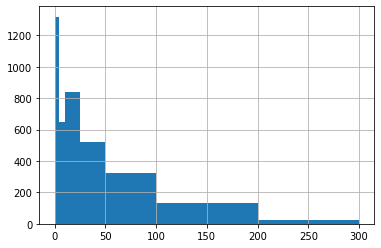

In [46]:
bins = [0, 4,10,25,50,100,200,300]
listings.number_of_reviews.hist(bins=bins)